# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/hw_3_iad_smmo"
PATH_TO_TRAIN_DATA = 'train.csv'

Mounted at /content/drive
/content/drive/MyDrive/hw_3_iad_smmo


In [26]:
import pandas as pd

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

val_test = pd.read_csv('test.csv')

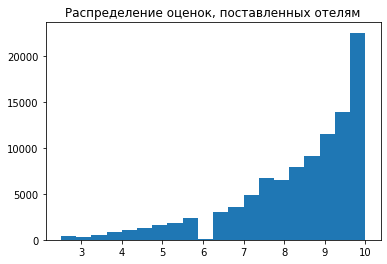

In [3]:
import matplotlib.pyplot as plt
plt.title('Распределение оценок, поставленных отелям')
plt.hist(df['score'], bins = 20)
plt.show()

In [4]:
df['score'].mean()

8.398282999999289

In [5]:
df['score'].median()

8.8

In [ ]:
len(y_test)

25000

In [12]:
import numpy as np
def stretch_func(arr, length=1):
    repetitions = np.round(np.linspace(0,length,arr.shape[0]+1))[1:] - np.round(np.linspace(0,length,arr.shape[0]+1))[:-1]
    repeated = np.repeat(arr, repetitions.astype(np.int))
    return repeated

median = stretch_func(np.array([df['score'].median()]), length=len(y_test))
mean_absolute_error(median, y_test)

1.2592199999999998

## Вывод: Любой адекватный алгоритм выдаст МАЕ не больше 1.259

Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [7]:
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize

def process_text(text):
    return [word for word in word_tokenize(text.lower()) if word not in (string.punctuation or string.stopwords)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [28]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error

In [29]:
X_train = (df_train['negative'] + df_train['positive']).to_numpy()
y_train = df_train['score'].to_numpy()

X_test = (df_test['negative'] + df_test['positive']).to_numpy()
y_test = df_test['score'].to_numpy()

X_overall = (df['negative'] + df['positive']).to_numpy()

In [24]:
tf_idf_vector = TfidfVectorizer(ngram_range=(1,4))

In [30]:
text_train = [' '.join(x) for x in X_train]
text_test = [' '.join(x) for x in X_test]
text_overall = [' '.join(x) for x in X_overall]

tf_idf_vector.fit(text_overall)
X_train_tfidf = tf_idf_vector.transform(text_train)
X_test_tfidf = tf_idf_vector.transform(text_test)

In [41]:
model_1 = LinearRegression()
model_1.fit(X_train_tfidf, y_train)

KeyboardInterrupt: ignored

In [ ]:
y_pred = model_1.predict(X_test_tfidf)
print ('Качество модели на TF-IDF векторах текстов составило', round(mean_absolute_error(y_pred, y_test),4))

Качество модели на TF-IDF векторах текстов составило 0.885


Отлично, 1 балл есть, больше и не надо...

### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах. 

In [39]:
#text_train_2 = pd.DataFrame(text_train)
#text_test_2 = pd.DataFrame(text_test)
texts_word2vec = []
for sentence in text_overall:
  texts_word2vec.append(sentence.split())

from gensim.models import Word2Vec
model_2 = Word2Vec(sentences=texts_word2vec, size=100, window=5, min_count=1, workers=4)
model_2.save("word2vec.model")

In [45]:
model_2_val = LinearRegression()
model_2_val.fit(np.array([model_2[word] for word in text_train.split()]).reshape(1, -1), df_train['score'])

AttributeError: ignored

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [ ]:
def calc_idf(texts):
    pass

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 
#### Сделайте выводы:

Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.
#### Выводы: это полугодие иада точно мне не по душе. Эта домашка пришлась на этап, во время которого у меня было 3 экзамена, защита проекта, необходимость проверки 50 домашек по диффурам и ещё 10 контрольных по диффурам. Как итог я сел за него вечером воскресенья и не смог ничего из себя выжать. Простите.

### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [16]:
import torch
from torch import nn
from torch.nn import functional as F

In [17]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [18]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [19]:
MAX_LEN = max(max(df['positive'].apply(len)), max(df['negative'].apply(len)))

In [20]:
MAX_LEN

1965

In [21]:
from torch.nn.utils.rnn import pad_sequence

train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['positive']], 
                           batch_first=True)

KeyError: ignored

In [36]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self._tokens = df[0]
        self.targets = df[1]
        pass
        
    def __len__(self):
        return len(self._tokens)
    
    def __getitem__(self, idx):
        return self._tokens[idx], torch.as_tensor(self.targets[idx])

In [46]:
BATCH_SIZE = 1

train_dataset = ReviewsDataset(text_train)
test_dataset = ReviewsDataset(text_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
NUM_EPOCHS = 1

for n in range(NUM_EPOCHS):
    model_1.train()
    ## TODO

### Бонус. 10 баллов

Побейте качество 0.75 в [соревновании](https://www.kaggle.com/c/hseds-texts-2020/leaderboard). Можете воспользоваться вышеперечисленными методами или попробовать что-нибудь еще.